In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sys
sys.path.append("../ComSub")
from ECI  import *
import re
from collections import defaultdict, Counter
from datetime import datetime as dt
p1 = re.compile(r'[<](.*?)[>]', re.S)  #最小匹配

In [886]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_dict(lst):
    return dict(zip(list(set(lst)),range(len(set(lst)))))
def str2time(string,Format = '%Y-%m-%dT%H:%M:%S'):
    return dt.strptime(string[:19],Format)
def get_timedelta_secend(time1,time2,Format = '%Y-%m-%dT%H:%M:%S'):
    if Format:
        delta = dt.strptime(time2[:19],Format)-dt.strptime(time1[:19],Format)
    else:
        delta = time2-time1
    return delta.seconds
def get_timedelta(time1,time2,Format = '%Y-%m-%dT%H:%M:%S'):
    if  Format:
        delta = dt.strptime(time2[:19],Format)-dt.strptime(time1[:19],Format)
    else:
        delta = time2-time1
    delta = int(delta.seconds/60)
    return delta

In [842]:
data = pd.read_csv("./Posts_phys_wt.csv")
# wt = []
# nan  = data.AcceptedAnswerId[7]
# for i in data.index:
#     if data.PostTypeId[i]==1 and not np.isnan(data.AcceptedAnswerId[i]):
#         time1 = data.CreationDate[i][:-4]
#         time2 = list(data[data.Id==data.AcceptedAnswerId[i]].CreationDate)[0][:-4]
#         delta = dt.strptime(time2,'%Y-%m-%dT%H:%M:%S')-dt.strptime(time1,'%Y-%m-%dT%H:%M:%S')
#         delta = int(delta.seconds/60)
#     else:
#         delta = np.NaN
#     wt.append(delta)
# data['WaitingTime']=wt
# data.to_csv ("./Posts_phys_wt.csv", index = None, header=True)

In [1008]:
data.head()

,PostTypeId,Id,OwnerUserId,CreationDate,AcceptedAnswerId,Tags,ParentId,Score,CommentCount,ViewCount,AnswerCount,FavoriteCount,Title,Body,WaitingTime
0,1,1,7.0,2010-11-02T18:59:01.140,5.0,<quantum-mechanics><particle-physics><angular-...,NaN,68,5,12383.0,4.0,23.0,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...,16.0
1,1,2,23.0,2010-11-02T19:09:48.680,5704.0,<particle-physics><string-theory>,NaN,27,3,2276.0,4.0,8.0,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...,804.0
2,1,3,40.0,2010-11-02T19:11:05.857,180.0,<particle-physics><group-theory><representatio...,NaN,32,5,2113.0,3.0,12.0,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...,120.0
3,2,4,20.0,2010-11-02T19:12:26.543,NaN,NaN,1.0,19,2,NaN,NaN,NaN,NaN,<p>Imagine going to the rest frame of a massiv...,NaN
4,2,5,13.0,2010-11-02T19:15:20.813,NaN,NaN,1.0,42,0,NaN,NaN,NaN,NaN,<p>Spin is a technical term specifically refer...,NaN


存在的关系
- 提问者-问题 
- 回答者-问题
- 回答者-tag的关系

In [391]:
#找到所有的问题和回答
Question = data[data.PostTypeId==1]
Answer = data[data.PostTypeId==2]

In [143]:
#所有问题的标签
Qid_tags =  {Question.Id[i]:p1.findall(Question.Tags[i]) for i in Question.index}

In [144]:
# 所有标签的列表
taglist = list(set([t for i in Qid_tags for t in Qid_tags[i]]))
dtag = dict(zip(taglist,range(len(taglist))))

In [146]:
AnswerUserTag = defaultdict(lambda:defaultdict(lambda: 0))
for i in Answer.index:
    user = Answer.OwnerUserId[i]
    qid = int(Answer.ParentId[i])
    if qid in Qid_tags:
        for tag in Qid_tags[qid]:
            AnswerUserTag[user][tag]+=1


In [147]:
user_tag = [[user,tag,AnswerUserTag[user][tag]] for user in AnswerUserTag for tag in  AnswerUserTag[user]]

In [148]:
x = [a for a,b,c in user_tag]
y = [b for a,b,c in user_tag]
z = [c for a,b,c in user_tag]
dx = get_dict(x)
dy = get_dict(y)
xlist = [dx[a] for a in x]
ylist = [dy[b] for b in y]
from scipy import sparse
nx,ny=len(dx),len(dy)
M = sparse.csc_matrix((z,(xlist,ylist)),shape=(nx,ny))

In [152]:
R = RCA_sparse(M)
D = Get_eci_pci_sparse(R)

==Time 3.73==
==Time 0.14==


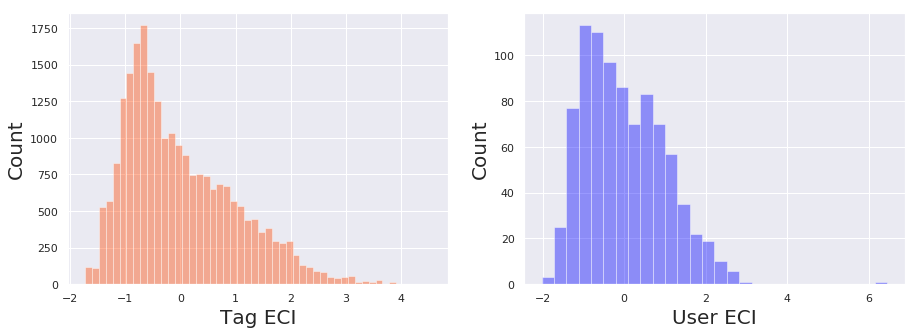

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(D['eci'],kde=False,color="orangered",)
plt.xlabel('Tag ECI',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.subplot(122)
sns.distplot(D['pci'],kde=False,color="blue",)
plt.xlabel('User ECI',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.show()

In [154]:
res = [(key,D['pci'][dy[key]]) for key in dy]
Res = sorted(res,key=lambda  x:x[1],reverse=True)
Res[:20]

[('quantum-error-correction', 6.463757587406002),
 ('wightman-fields', 3.1221173276601535),
 ('affine-lie-algebra', 2.7604364301223097),
 ('superspace-formalism', 2.560976989989733),
 ('hopf-algebra', 2.5479013559563892),
 ('large-n', 2.546982098617455),
 ('algebraic-topology', 2.5359186633548023),
 ('amplituhedron', 2.5287466772888827),
 ('sigma-models', 2.509364795728365),
 ('string-field-theory', 2.5078306313353913),
 ('calabi-yau', 2.3875774723484313),
 ('topological-defects', 2.382500742747014),
 ('skyrmion', 2.3471149233650954),
 ('brst', 2.337258295839197),
 ('research-level', 2.3182699482268054),
 ('chern-simons-theory', 2.2951913128778414),
 ('conformal-field-theory', 2.271234211357312),
 ('supersymmetry', 2.259894261726987),
 ('superconformality', 2.2021466813934825),
 ('non-commutative-geometry', 2.14605407742623)]

In [155]:
Res[-20:]

[('aircraft', -1.4849019487784323),
 ('drag', -1.4908179351006468),
 ('water', -1.4932421937930964),
 ('humidity', -1.4959362367879132),
 ('contact-mechanics', -1.5064492044506188),
 ('lift', -1.512611677321254),
 ('bernoulli-equation', -1.51976164121583),
 ('electricity', -1.5630536315786463),
 ('electrical-resistance', -1.5664219316478243),
 ('pressure', -1.5667629124821618),
 ('everyday-life', -1.569747586758768),
 ('fluid-dynamics', -1.586555976440661),
 ('aerodynamics', -1.599324971465454),
 ('free-body-diagram', -1.627645113727728),
 ('electric-circuits', -1.6570894398813922),
 ('forces', -1.664724621237131),
 ('friction', -1.6655668624243072),
 ('telescopes', -1.8129050499919555),
 ('newtonian-mechanics', -1.829506545246723),
 ('fracture', -2.025059425989051)]

# 利用userid-questionid

In [ ]:
考虑的问题 需要去处理那些被accepted的问题

In [394]:
Question1 =  Question.dropna(subset=["OwnerUserId"])
Answer1 =  Answer.dropna(subset=["OwnerUserId","ParentId"])

In [395]:
Question1.head()

,PostTypeId,Id,OwnerUserId,CreationDate,AcceptedAnswerId,Tags,ParentId,Score,CommentCount,ViewCount,AnswerCount,FavoriteCount,Title,Body,WaitingTime
0,1,1,7.0,2010-11-02T18:59:01.140,5.0,<quantum-mechanics><particle-physics><angular-...,NaN,68,5,12383.0,4.0,23.0,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...,16.0
1,1,2,23.0,2010-11-02T19:09:48.680,5704.0,<particle-physics><string-theory>,NaN,27,3,2276.0,4.0,8.0,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...,804.0
2,1,3,40.0,2010-11-02T19:11:05.857,180.0,<particle-physics><group-theory><representatio...,NaN,32,5,2113.0,3.0,12.0,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...,120.0
5,1,7,23.0,2010-11-02T19:26:38.137,46.0,<quantum-mechanics><quantum-interpretations><h...,NaN,10,5,1849.0,6.0,5.0,Will Determinism be ever possible?,<p>What are the main problems that we need to ...,87.0
7,1,9,48.0,2010-11-02T19:28:09.013,NaN,<lagrangian-formalism><variational-principle><...,NaN,39,1,6586.0,6.0,27.0,Hamilton's Principle,<p>Hamilton's principle states that a dynamic ...,NaN


In [157]:
XY = [[int(Answer.OwnerUserId[i]), int(Answer.ParentId[i])] for i in Answer1.index]

In [158]:
x = [i  for  i,j  in XY]
y = [j  for  i,j  in XY]

In [159]:
Cx = Counter(x)
Cy= Counter(y)

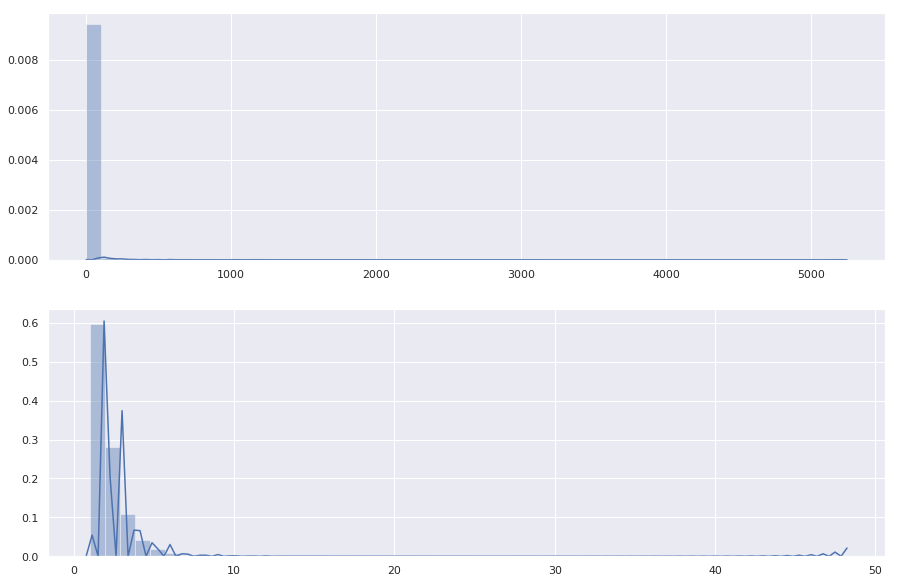

In [177]:
plt.figure(figsize=(15,10))
plt.subplot(211)
sns.distplot(list(Cx.values()))
plt.subplot(212)
sns.distplot(list(Cy.values()))

In [781]:
removex = [i for i in Cx if Cx[i]<=1]
removey = [i for i in Cy if Cy[i]<=2]
XY1 = []
n=0
N=len(XY)
for xi,yi in XY:
    if xi not in removex and yi not in removey:
        XY1.append([xi,yi])
    n+=1
    if n%1000==0:
        print(n*1.0/N,end='\r')

In [759]:
x = [i  for  i,j  in XY1]
y = [j  for  i,j  in XY1]
dx = get_dict(x)
dy = get_dict(y)
xlist = [dx[a] for a in x]
ylist = [dy[b] for b in y]
len(dx),len(dy)

(4553, 6696)

In [760]:
nx,ny=len(dx),len(dy)
M = sparse.csc_matrix(([1.]*len(xlist),(xlist,ylist)),shape=(nx,ny))

In [761]:
R = RCA_sparse(M)
#D = Get_eci_pci_sparse(R)

/home/superman/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:282: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


==Time 5.04==


In [222]:
@timelogger
def Get_eci_pci(M):
    d = M.sum(1).T.tolist()[0]
    u = M.sum(0).tolist()[0]
    D = np.diag([1.0/i if i>0 else 0. for i in d])
    U = np.diag([1.0/i if i>0 else 0. for i in u])
    mcp1 = D * M
    mcp2 = M * U
    
    Mcc = mcp1 * mcp2.T
    Mpp = mcp2.T * mcp1
    eigvals, eigvecs = np.linalg.eig(Mpp)
    eigvecs = np.real(eigvecs)
    # Get eigenvector corresponding to second largest eigenvalue
    eig_index = eigvals.argsort()[-2]
    kp = eigvecs[:, eig_index]
    kc = mcp1 @ kp
    s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
    eci = s1 * kc
    pci = s1 * kp  
    return {'eci':eci.T.tolist()[0],'pci':pci.T.tolist()[0]}

In [762]:
D = Get_eci_pci_sparse(M)

==Time 1.02==


In [763]:
eci = D['eci']
pci = D['pci']
# eci[abs(eci)>0.025]=0.025
# pci[abs(pci)>0.025]=0.025

In [478]:
def filter_extream(eci):
    mark1 =0
    mark2 =0
    n=0
    seci = sorted(eci,reverse=True)
    for i in range(1,len(seci)):
        if seci[i]/seci[i-1]<1:
            mark1 = seci[i]
            break
    seci = sorted(eci)
    for i in range(1,len(seci)):
        if seci[i]/seci[i-1]>1:
            mark2 = seci[i]
            break
    eci[eci>mark1]=mark1
    eci[eci<mark2]=mark2
    return eci

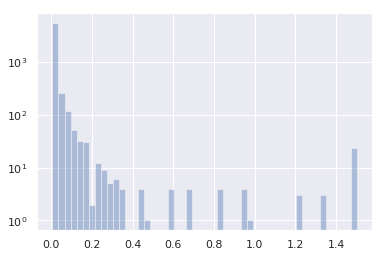

In [534]:
eci1 =  filter_extream(eci)
eci1 = Get_z_score(eci1)
eci1 =  filter_extream(eci1)
eci1 =  filter_extream(eci1)
eci1 =  filter_extream(eci1)
eci1 =  filter_extream(eci1)
eci1 =  filter_extream(eci1)
eci1 =  filter_extream(eci1)
sns.distplot(eci1,kde=False)
plt.yscale('log')

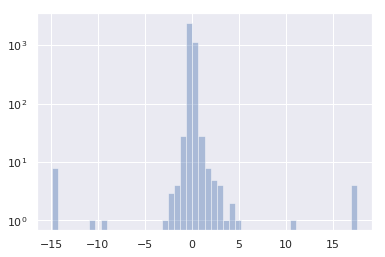

In [284]:
sns.distplot(Get_z_score(eci),kde=False)
plt.yscale('log')

In [285]:
Get_z_score(eci)

array([-0.30328026,  0.84437662,  0.02108168, ...,  0.02108168,
        0.66980554,  0.07101196])

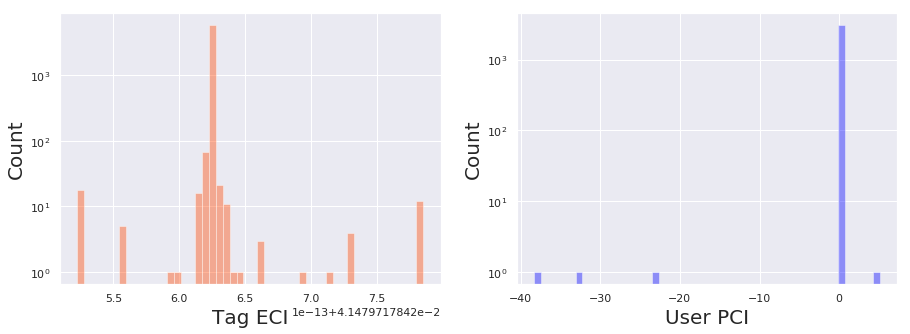

In [536]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.yscale('log')
sns.distplot(D['eci'],kde=False,color="orangered",)
plt.xlabel('Tag ECI',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.subplot(122)
sns.distplot(D['pci'],kde=False,color="blue",)
plt.xlabel('User PCI',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.yscale('log')
plt.show()

In [537]:
pci1 = filter_extream(D['pci'])

In [775]:
len(pci)

6696

In [776]:
SD =  sorted([[i,k]  for i,k in zip(range(len(pci)),pci)],key=lambda x:x[1],reverse=True)

In [765]:
qid = [i for i in dy.keys()]
qid2 = [dy[i] for i in qid]

In [766]:
id2origin=dict(zip(qid2,qid))

In [735]:
QS  = {int(key):QS[key] for key in QS }

In [774]:
len(pci1)

3097

In [777]:
tmp =[]
nn=0
for i,j in SD:
    if not np.isnan(list(data.loc[data['Id']==id2origin[i]].WaitingTime)[0]):
        WaitingTime = list(data.loc[data['Id']==id2origin[i]].WaitingTime)[0]
        ViewCount= list(data.loc[data['Id']==id2origin[i]].ViewCount)[0]
        AnswerCount = list(data.loc[data['Id']==id2origin[i]].AnswerCount)[0]
        TagCount = len(p1.findall(list(data.loc[data['Id']==id2origin[i]].Tags)[0]))
        if id2origin[i] in QS:
            TureSkill = QS[id2origin[i]]
            tmp.append([id2origin[i],j,WaitingTime,ViewCount,AnswerCount,TagCount,TureSkill])
            nn+=1
        if nn%100:
            print(nn,end='\r')

In [780]:
len(QS)

57155

In [754]:
len(SD)

3097

In [778]:
XYZ = np.array(tmp)

In [779]:
scipy.stats.spearmanr(XYZ[:,1],XYZ[:,-1])#eci,trueskill

SpearmanrResult(correlation=-0.0024218004481290937, pvalue=0.8848265875768304)

In [750]:
scipy.stats.spearmanr(XYZ[:,2],XYZ[:,3])#WaitingTime,ViewCount

SpearmanrResult(correlation=-0.16061575687926044, pvalue=2.951073613665708e-11)

In [790]:
scipy.stats.pearsonr(XYZ[:,2],XYZ[:,4]/XYZ[:,3])##WaitingTime,AnswerCount

(0.007910408083729526, 0.6361087614015408)

Text(0, 0.5, 'WaitingTime')

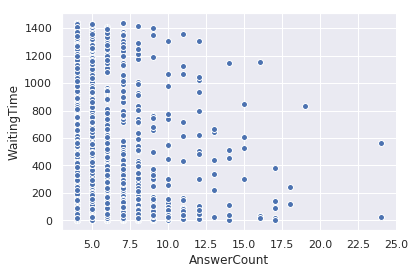

In [795]:
plt.scatter(XYZ[:,4],XYZ[:,2],edgecolors='w')
plt.xlabel('AnswerCount')
plt.ylabel('WaitingTime')

In [798]:
Dict=defaultdict(lambda:[])
for c,t,v in zip(XYZ[:,4],XYZ[:,2],XYZ[:,3]):
    
    Dict[c].append(t)

In [816]:
x = sorted(list(Dict.keys()))

In [818]:
y = [Dict[xi] for xi in x]

Text(0.5, 0, '#Answer')

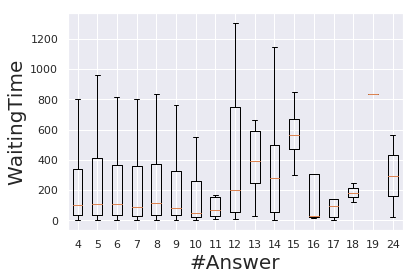

In [819]:
plt.boxplot(y,showfliers=False)
plt.xticks(range(1,len(x)+1),[int(i) for i in x])
plt.ylabel("WaitingTime",fontsize=20)
plt.xlabel("#Answer",fontsize=20)

Text(0.5, 0, '#Answer')

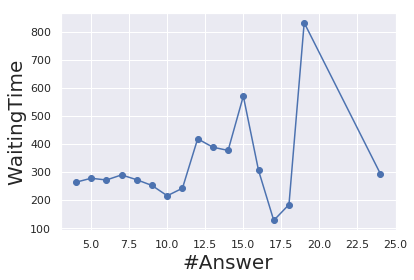

In [822]:
y1 = [np.mean(Dict[xi]) for xi in x]
plt.plot(x,y1,'o-')
plt.ylabel("WaitingTime",fontsize=20)
plt.xlabel("#Answer",fontsize=20)

In [751]:
scipy.stats.spearmanr(XYZ[:,1],XYZ[:,3])#eci,ViewCount

SpearmanrResult(correlation=-0.0032439655756215224, pvalue=0.8938630624168851)

In [545]:
scipy.stats.spearmanr(XYZ[:,1],XYZ[:,4])#eci,AnswerCount

SpearmanrResult(correlation=-0.011590977039442854, pvalue=0.627108015058393)

In [546]:
scipy.stats.spearmanr(XYZ[:,1],XYZ[:,5])#eci,TagCount

SpearmanrResult(correlation=-0.0076474854202048664, pvalue=0.7485775503570908)

In [589]:
num,sps,pvs=[],[],[]
for i in range(1,6):
    xyz1 = XYZ[XYZ[:,5]==i]
    sp,pv = scipy.stats.spearmanr(xyz1[:,1],xyz1[:,2])
    num.append(i)
    sps.append(sp)
    pvs.append(pv)
pd.DataFrame({'#Tag':num,"spearmanr":sps,"pvs":pvs})

,#Tag,spearmanr,pvs
0,1,0.165263,0.037362
1,2,-0.058582,0.273022
2,3,-0.072591,0.115651
3,4,-0.062249,0.205136
4,5,0.058811,0.265066


In [607]:
np.where(~np.isnan(npwt))[0]

array([     0,      1,      2, ..., 284451, 284462, 284479])

In [622]:
min(tmp)

0.0

In [630]:
num,bins=np.histogram(tmp)

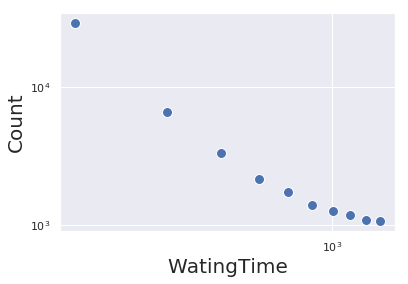

In [637]:
npwt=np.array(list(data.WaitingTime))
tmpwt = npwt[np.where(~np.isnan(npwt))[0]]
plt.scatter(bins[1:],num,edgecolors='w',s=100,color='b')
plt.xlabel("WatingTime",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.yscale('log')
plt.xscale('log')

In [663]:
np.log(xx+1)

array([2.31051287e+00, 2.31051287e+00, 2.31051287e+00, ...,
       1.74937072e-03, 1.74937072e-03, 1.74937072e-03])

/home/superman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/superman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Text(0, 0.5, 'log_(WT+1)')

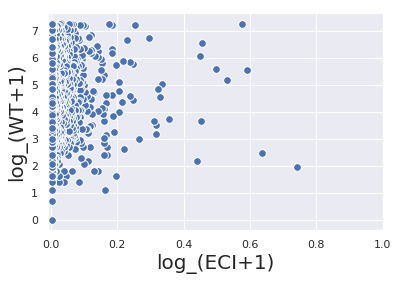

In [668]:
XYZ = np.array(tmp)
xx = filter_extream(Get_z_score(filter_extream(XYZ[:,1])))
plt.scatter(np.log(xx+1) ,np.log(XYZ[:,2]+1),edgecolors='w',s=60)
plt.xlim([-0.01,1])
plt.xlabel('log_(ECI+1)',fontsize=20)
plt.ylabel('log_(WT+1)',fontsize=20)


In [680]:
#互补性问题难度
q_tag = [ [qid,tag] for qid in Qid_tags for tag in Qid_tags[qid]]
x = [a for a,b in q_tag]
y = [b for a,b in q_tag]
z = [1.0]*len(x)
dx = get_dict(x)
dy = get_dict(y)
xlist = [dx[a] for a in x]
ylist = [dy[b] for b in y]
from scipy import sparse
nx,ny=len(dx),len(dy)
M = sparse.csc_matrix((z,(xlist,ylist)),shape=(nx,ny))


In [686]:
id2yname = {dy[key]:key for key in dy}

In [681]:
M.shape

(115263, 896)

In [682]:
M0 = M.T*M
M1 = M0 / M0.sum(axis=0)
M2=np.zeros((len(M1),len(M1)))
M3=copy.deepcopy(M1)
for k in range(2,10):
    M3 = M3*M1
    M2+=M3
M2=M2 / M2.sum(axis=0)
Md = M0.todok()
index = list(dict(Md).keys())


In [687]:
K1 = M1/M2
K=[[i,j,K1[i,j]] if M1[i,j]>0 else [i,j,-M2[i,j]] for i in range(len(M1)) for j  in range(len(M1)) if i>j]
SW = sorted(K,key=lambda x:x[2],reverse=True)
tmp =[]
for i,j,k in SW:
    try:
        tmp.append([id2yname[i],id2yname[j],k])
    except:
        pass
print(pd.DataFrame(tmp,columns=['name1','name2','ComSub']).head())
print(pd.DataFrame(tmp,columns=['name1','name2','ComSub']).tail())

                 name1         name2     ComSub
0             spin-ice   spin-liquid  12.627649
1   symmetry-protected           spt  11.894295
2      mirror-symmetry    calabi-yau  11.515401
3  topological-defects      skyrmion  11.459578
4          sine-gordon  bosonization  10.947877
                         name1                     name2    ComSub
400955                  optics      strong-field-physics -0.044270
400956    quantum-field-theory  supersymmetric-particles -0.044974
400957  homework-and-exercises          self-capacitance -0.046267
400958  homework-and-exercises         contact-mechanics -0.051284
400959    quantum-field-theory                  adinkras -0.052868


In [698]:
avgK = K1.sum(1).T.tolist()[0]
tmp =[]
for i in range(len(avgK)):
    tmp.append([id2yname[i],avgK[i]])
tmp = sorted(tmp,key=lambda x:x[1])
pdavg_K=pd.DataFrame(tmp,columns=['name','ComSub'])

In [706]:
dtag_k=dict(zip([x for x,y in tmp],[y for x,y in tmp]))

In [707]:
avg_klst = []
for i in Question.index:
    avg_klst.append([dtag_k[tag] for tag in Qid_tags[Question.Id[i]]])

In [710]:
lst1 = [np.mean(tmp) for tmp in avg_klst]
lst2 = [sum(tmp) for tmp in avg_klst]

In [711]:
Question['avg_K']=lst1
Question['sum_K']=lst2

/home/superman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/superman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [713]:
Q2 = Question.dropna(subset=["WaitingTime"])

In [714]:
a = list(Q2['WaitingTime'])
b = list(Q2['avg_K'])
c = list(Q2['sum_K'])

Text(336.9714285714286, 0.5, 'WaitingTime')

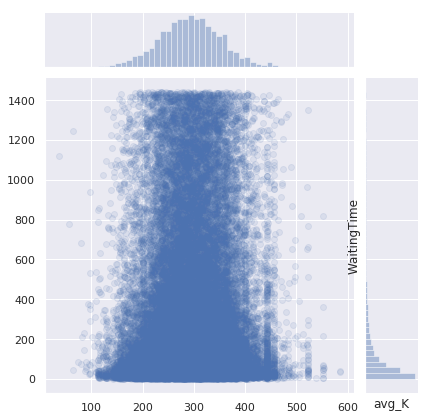

In [720]:
sns.jointplot(b,a,alpha=0.1)
plt.xlabel("avg_K")
plt.ylabel("WaitingTime")

Text(336.9714285714286, 0.5, 'WaitingTime')

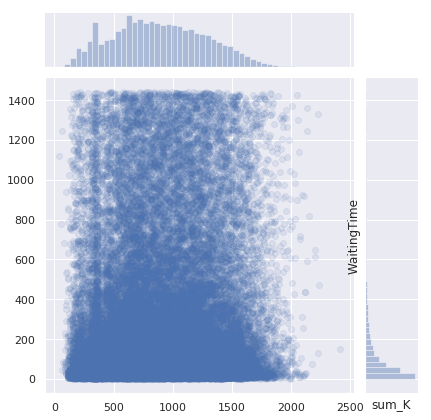

In [721]:
sns.jointplot(c,a,alpha=0.1)
plt.xlabel("sum_K")
plt.ylabel("WaitingTime")

In [724]:
scipy.stats.pearsonr(c,a)

(0.07028635069280727, 9.199863497461156e-55)

In [723]:
scipy.stats.spearmanr(b,a)

SpearmanrResult(correlation=0.04592659752896073, pvalue=2.528062024657432e-24)

In [725]:
import pickle

In [726]:
with open('./QS.pkl','rb')as f:
    QS= pickle.load(f)

# 问题回答人数与被接受概率的关系
假设被接受概率P，回答人数N
$$P = 1-(1-p)^N$$ 
对于给定的回答者人数$N_i$，统计具有相同回答人数的问题，被回答出来的概率$P_i$是多少。
- 如果是相比null model超线性就说明知识是可以被拆解的，可以通过积累来提高概率
- 如果相比null model 亚线性说明知识是不可拆解的，不可以通过节累来提高概率

In [829]:
# QuestionAnswer
QA = defaultdict(lambda:[])
for i in Answer.index:
    aid = Answer.Id[i]
    qid = Answer.ParentId[i]
    QA[qid].append(aid)

In [896]:
def SortTime(atlst):
    res = sorted(atlst,key=lambda x:x[1])
    return [a for a,t in res]

In [848]:
QA[qid]

[4, 5, 34567, 137669]

In [881]:
def getDfvalue(df,Id,label=None):
    return df[label][df['Id']==Id].values[0]
@timelogger
def save_pkl(D,fname=None):
    with open(fname,'wb') as f:
        pickle.dump(D,f)
    return 0
@timelogger
def load_pkl(D,fname=None):
    with open(fname,'rb') as f:
        D = pickle.load(f)
    return D

In [889]:
Time={}
for i in data.index:
    did = data.Id[i]
    Time[did] = str2time(data.CreationDate[i])

In [898]:
QA_sortbytime={}
QA_uptoaccept={}
for qid  in QA:
    atlst = [(aid,Time[aid]) for aid in QA[qid]]
    QA_sortbytime[qid] = SortTime(atlst)
    aid_accepted = getDfvalue(Question,qid,label='AcceptedAnswerId')
    if not np.isnan(aid_accepted):
        QA_uptoaccept[qid] = [aid  for aid in QA_sortbytime[qid] if Time[aid_accepted]>=Time[aid]]

In [900]:
save_pkl(QA_sortbytime,fname="./QA_sortbytime.pkl")
save_pkl(QA_uptoaccept,fname="./QA_uptoaccept.pkl")

==Time 0.80==
==Time 0.36==


0

In [904]:
tmp = np.array([[len(QA_uptoaccept[i]),len(QA_sortbytime[i])] for i in QA_uptoaccept])

Text(0, 0.5, '#TotalAnswer')

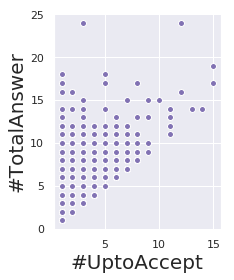

In [915]:
plt.figure(figsize=(3,4))
plt.scatter(tmp[:,0],tmp[:,1],edgecolors='w',c='m')
plt.xlabel('#UptoAccept',fontsize=20)
plt.ylabel('#TotalAnswer',fontsize=20)

In [987]:
Q_AcceptTeam=defaultdict(lambda:[])
Q_TotalTeam = defaultdict(lambda:[])
for qid in QA:
    if qid in QA_uptoaccept:
        tn = len(QA_uptoaccept[qid])
        #tn = len(QA_sortbytime[qid])
        Q_AcceptTeam[tn].append(qid)
    else:
        tn = len(QA_sortbytime[qid])
    Q_TotalTeam[tn].append(qid)

In [988]:
Ts = sorted(Q_TotalTeam.keys())
Ns = [len(Q_TotalTeam[ts]) for ts in Ts]
sNs = np.cumsum(Ns)
P=[]
for ts in  Ts:
    P.append(len(Q_AcceptTeam[ts])/len(Q_TotalTeam[ts]))

Text(0, 0.5, 'P(Accepted)')

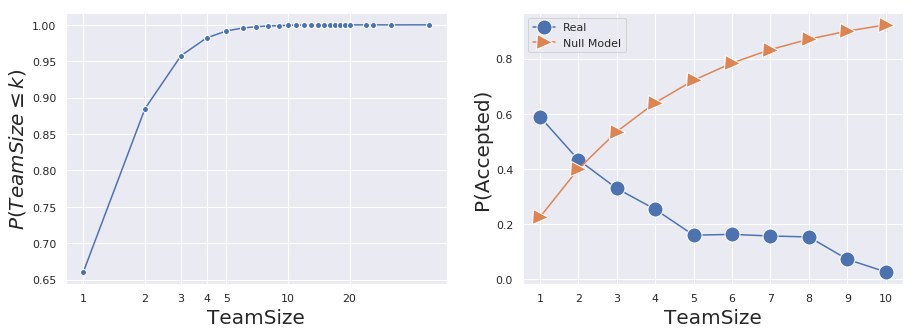

In [989]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(Ts,sNs/sNs[-1],'o-',mec='w')
plt.xscale('log')
plt.xticks([1,2,3,4,5,10,20],[1,2,3,4,5,10,20])
plt.xlabel('TeamSize',fontsize=20)
plt.ylabel("$P(TeamSize\leq k)$",fontsize=20)
plt.subplot(122)
plt.plot(Ts[:10],P[:10],'o-',ms=15,mec='w',label='Real')
plt.plot(Ts[:10],[func(t,pc) for t in range(1,11)],'>-',mec='w',label='Null Model',ms=15)
plt.legend()
plt.xticks(range(1,11),range(1,11))
plt.xlabel('TeamSize',fontsize=20)
plt.ylabel("P(Accepted)",fontsize=20)

In [982]:
from scipy.optimize import curve_fit
def func(x,p):
    return 1-(1-p)**x
popt, pcov = curve_fit(func,Ts[:5],P[:5])
pc = popt[0]

In [999]:
# 按照Tag数量来控制
Q_AcceptTeambyTag=defaultdict(lambda:defaultdict(lambda:[]))
Q_TotalTeambyTag = defaultdict(lambda:defaultdict(lambda:[]))
for qid in QA:
    ntag = len(Qid_tags[qid])
    if qid in QA_uptoaccept:
        tn = len(QA_uptoaccept[qid])
        #tn = len(QA_sortbytime[qid])
        Q_AcceptTeambyTag[ntag][tn].append(qid)
    else:
        tn = len(QA_sortbytime[qid])
    Q_TotalTeambyTag[ntag][tn].append(qid)

Text(0, 0.5, 'P(Accepted)')

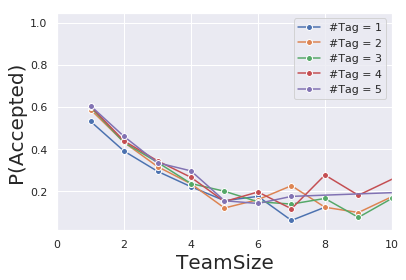

In [1007]:
for i in range(1,6):
    Pi=[]
    Tsi=sorted(Q_AcceptTeambyTag[i].keys())
    for tn in Tsi:
        Pi.append(len(Q_AcceptTeambyTag[i][tn])/len(Q_TotalTeambyTag[i][tn]))
    plt.plot(Tsi,Pi,'o-',mec='w',label="#Tag = %d"%(i))
plt.legend()
plt.xlim(0,10)
plt.xlabel('TeamSize',fontsize=20)
plt.ylabel("P(Accepted)",fontsize=20)

In [1001]:
Q_TotalTeambyTag.keys()

dict_keys([4, 3, 2, 5, 1])